In [2]:
import numpy as np
from numpy import inf
import sys
import json
import matplotlib.pyplot as plt
import mido
import copy
import time

from sklearn.decomposition import PCA

In [3]:
direc="data/test_midi/bach_prelude_1.mid"

In [4]:
m = mido.MidiFile(direc)

In [5]:
def midifile_to_dict(mid):
    tracks = []
    for track in mid.tracks:
        tracks.append([vars(msg).copy() for msg in track])

    return {
        'ticks_per_beat': mid.ticks_per_beat,
        'tracks': tracks,
    }


mid = m
mid_dict_pure = midifile_to_dict(mid)

In [6]:
mid_dict_pure['tracks'][0]

[{'type': 'track_name', 'name': 'Piano right\x00', 'time': 0},
 {'type': 'time_signature',
  'numerator': 4,
  'denominator': 4,
  'clocks_per_click': 36,
  'notated_32nd_notes_per_beat': 8,
  'time': 0},
 {'type': 'time_signature',
  'numerator': 4,
  'denominator': 4,
  'clocks_per_click': 36,
  'notated_32nd_notes_per_beat': 8,
  'time': 0},
 {'type': 'program_change', 'time': 0, 'program': 0, 'channel': 0},
 {'type': 'control_change',
  'time': 0,
  'control': 7,
  'value': 100,
  'channel': 0},
 {'type': 'control_change',
  'time': 0,
  'control': 10,
  'value': 64,
  'channel': 0},
 {'type': 'control_change',
  'time': 0,
  'control': 91,
  'value': 127,
  'channel': 0},
 {'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 61, 'channel': 0},
 {'type': 'note_on', 'time': 24, 'note': 64, 'velocity': 57, 'channel': 0},
 {'type': 'note_on', 'time': 24, 'note': 67, 'velocity': 56, 'channel': 0},
 {'type': 'note_off', 'time': 24, 'note': 67, 'velocity': 64, 'channel': 0},
 {'type': 

In [7]:
notes = []

midi_range=range(127)


mid_dict=copy.deepcopy(mid_dict_pure)

for i, track in enumerate(mid_dict['tracks']):
    tsum = 0
    for msg in track:
        tinc=msg['time']
        tsum+=tinc
#         if (msg['type']=='note_on' or msg['type']=='note_off') and msg['note']==60:
#             print(tsum,msg['time'],msg['type'],msg['note'])
#         else:
#             print(tsum,msg['time'],msg['type'])

        if (msg['type']=='note_on' or msg['type']=='note_off') and msg['note']==60:
            print(msg,tsum) 
            
        if msg['type']=="note_on":
            notes.append([msg['note'],tsum,tsum])#,msg['velocity']
        elif msg['type']=="note_off":
            for i in range(len(notes)-1,-1,-1):
                if notes[i][0]==msg['note']:
                    notes[i][2]=tsum
                    break


{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 61, 'channel': 0} 0
{'type': 'note_off', 'time': 24, 'note': 60, 'velocity': 64, 'channel': 0} 192
{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 62, 'channel': 0} 192
{'type': 'note_off', 'time': 0, 'note': 60, 'velocity': 64, 'channel': 0} 384
{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 65, 'channel': 0} 384
{'type': 'note_off', 'time': 24, 'note': 60, 'velocity': 64, 'channel': 0} 576
{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 65, 'channel': 0} 576
{'type': 'note_off', 'time': 0, 'note': 60, 'velocity': 64, 'channel': 0} 768
{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 61, 'channel': 0} 1152
{'type': 'note_off', 'time': 24, 'note': 60, 'velocity': 64, 'channel': 0} 1344
{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 62, 'channel': 0} 1344
{'type': 'note_off', 'time': 0, 'note': 60, 'velocity': 64, 'channel': 0} 1536
{'type': 'note_on', 'time': 0, 'note': 60, 'velocity': 67, 'chann

In [8]:
print(notes[0])

[60, 0, 192]


In [9]:
nar = np.array(notes)
print(nar[0],nar.shape)
nar[:,1:3]=nar[:,1:3]/24.
print(nar[0],nar.shape)

[ 60   0 192] (549, 3)
[60  0  8] (549, 3)


<IPython.core.display.Javascript object>


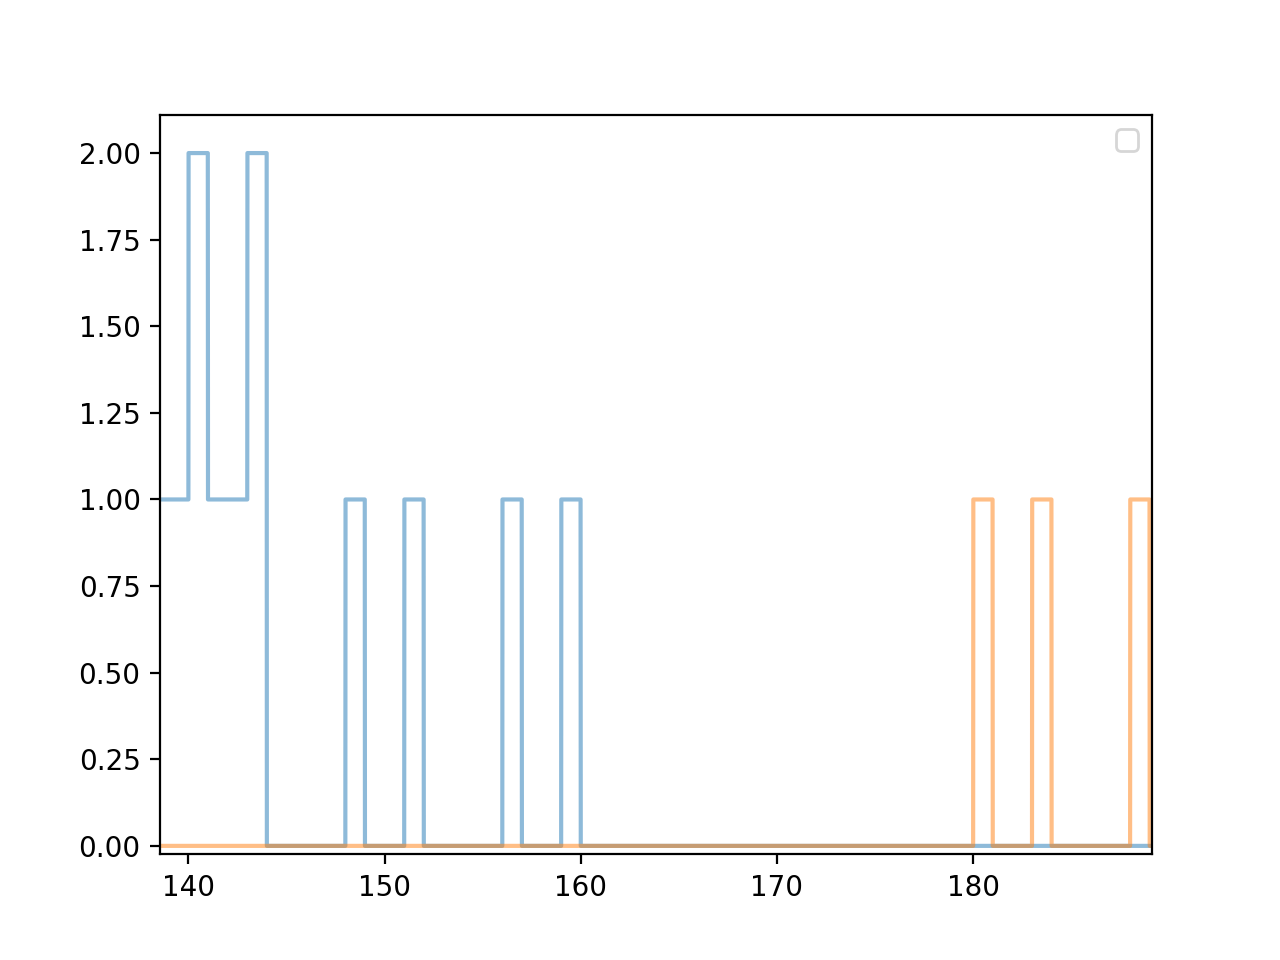

No handles with labels found to put in legend.


In [11]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

C=1000.

def sigmoid(x,i,c):
    return 1.0/(1.0+np.e**(c*(i-x)))

def bump(x, i, j, c):
    return sigmoid(x,i,c) + sigmoid(x,j,-c) - 1.


def integral_bump(x,i,j,c,const=0.):
    #a=(np.e**(-c*(j-x))+1.)
    #b=1./a
    #print(x,i,j,b,(np.e**(c*(i-x))+1.))
    ib=np.log((np.e**(c*(i-x))+1.)/(np.e**(-c*(j-x))+1.))/c + x + const
    ib[np.where(ib==inf)]=0.
    ib[np.where(ib==-inf)]=1.
    return ib

def bump_approx(x, i, j, c):
    b = np.zeros_like(x)
    b[np.where(np.logical_and(x>i,x<j))]=1.
    return b

def integral_bump_approx(x,i,j,c,const=0.):
    ib=np.copy(x-i)
    if len(ib.shape)>0:
        ib[np.where(x<=i)]=0.
        ib[np.where(x>=j)]=j-i
    else:
        if x<=i:
            ib=0.
        elif x>=j:
            ib=j-i
        else:
            ib=x-i
    return ib

def grad_bump(x,i,j,c):
    return sigmoid(x,i,c)*(1-sigmoid(x,i,c)) - sigmoid(x,j,-c)*(1-sigmoid(x,j,-c))

def build_func(x, music, pitch,f, c=C):
    s=0.
    if type(x)==np.ndarray and len(x.shape)>0:
        s=np.zeros(x.shape[0])
    for note in music:
        if note[0]%12 == pitch:
            s = s + f(x, note[1], note[2], c)
    return s

def build_integral_func(x,music,pitch,f_int,c=C):
    s=0.
    if type(x)==np.ndarray and len(x.shape)>0:
        s=np.zeros(x.shape[0])
    for note in music:
        if note[0]%12 == pitch:
            s = s + f_int(x, note[1], note[2], c)#-f_int(np.array([0]), note[1], note[2], c)
    return s


def get_notes_in_section(notes, t1, t2):
    nis = []
    for note in notes:
        if note[1]>=t1 and note[1]<=t2:
            if note[2]<t2:
                nis.append(note)
            else:
                nis.append([note[0],note[1],t2])
        elif note[1]<=t1 and note[2]>=t1:
            if note[2]>=t2:
                nis.append([note[0],t1,t2])
            else:
                nis.append([note[0],t1,note[2]])
    return np.array(nis)



music_func = lambda x, t1, t2: np.stack(map(lambda p: build_func(x, get_notes_in_section(nar, t1,t2), p, bump_approx), range(12)))
integral_music_func = lambda x, t1, t2: np.stack(map(lambda p: build_integral_func(x, get_notes_in_section(nar, t1,t2), p, integral_bump_approx), range(12)))


st,en=0,600

xs=np.arange(st,en,0.01)

y=music_func(xs, st, en)
#y2=music_func(xs, st, en)
#y3=music_func_t(xs, st, en)


pitches_use = range(2)

list(map(lambda x: plt.plot(xs,y[x],alpha=0.5),pitches_use))
plt.legend()


            

In [11]:
np.exp(700)

1.0142320547350045e+304

In [200]:
integral_music_func(np.array([0]),70,71.01)

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [433]:
SIGMA=5.
END = 35.*16.

def l2(x):
    return np.linalg.norm(x)

def clust_dist(ts,cs):
    s=0
    for i in range(cs.shape[0]):
        for j in range(cs.shape[0]):
            s+=l2(cs[i]-cs[j])**2
    return s

def grad_clust_dist(ts,cs):
    n=cs.shape[0]
    grad = [np.zeros_like(ts),np.zeros_like(cs)]
    clust_sum = np.sum(cs,axis=0)
    for i in range(n):
        for j in range(cs.shape[1]):
            grad[1][i,j] = 4*cs[i,j]*n - 4*(clust_sum[j]-cs[i,j])
    return grad


#CALC EXP DIST
def clust_tight(ts,cs,f,f_int,sigma=SIGMA):
    s=0
    note_ints=[]
    for i in range(ts.shape[0]):
        top_time=0.
        if i==ts.shape[0]-1:
            top_time=END
        else:
            top_time=ts[i+1]
        note_i = f_int(top_time,0,END)-f_int(ts[i],0,END)
        note_ints.append(note_i/np.linalg.norm(note_i))
    for i in range(ts.shape[0]):
        top_time=0.
        if i==ts.shape[0]-1:
            top_time=END
        else:
            top_time=ts[i+1]
        for j in range(cs.shape[0]):
            s+=np.exp((-1./sigma)*l2(note_ints[i]-cs[j])**2)
    return s


def grad_clust_tight(ts,cs,f,f_int,sigma=SIGMA):
    s=0
    dcs = np.zeros_like(cs)
    dts = np.zeros_like(ts)
    note_ints = []
    for i in range(ts.shape[0]):
        top_time=0.
        if i==ts.shape[0]-1:
            top_time=END
        else:
            top_time=ts[i+1]
        note_i = f_int(top_time,0,END)-f_int(ts[i],0,END)
        note_ints.append(note_i/np.linalg.norm(note_i))
    
    for k in range(cs.shape[0]):
        for p in range(cs.shape[1]):
            for i in range(ts.shape[0]):
                note_int = note_ints[i]
                S=np.sum((note_int-cs[k])**2)-(note_int[p]-cs[k,p])**2
                R=np.exp(-1./sigma * S)
                z = note_int[p]-cs[k,p]
                dcs[k,p] += 2*R*(1./sigma * (z**2 + S) - z)*np.exp(-(z**2)/sigma)
    return dts,dcs
        
def opt_func(ts,cs,mfunc,mfunc_integral):
    dist = clust_dist(ts,cs)
    tight= clust_tight(ts,cs,mfunc,mfunc_integral)
    return -dist+tight
    
def grad_opt_func(ts,cs,mfunc,mfunc_integral):
    dist = grad_clust_dist(ts,cs)
    tight = grad_clust_tight(ts,cs,mfunc,mfunc_integral)
    return -dist[0]+tight[0], -dist[1]+tight[1]
    

In [434]:
def sgd(func,grad,hess,x_init,x_opt,lr,decay,iters):
    t=time.time()
    dst = []
    trk = []
    
    
def adam(func,grad,hess,x_init,x_opt,lr,decay,iters,beta_1=0.9,beta_2=0.999):
    t=time.time()
    dst = []
    trk = []
    eps = 10.**-8
    x_i = [np.copy(k).astype(float) for k in x_init]
    m_i = [np.zeros(k.shape).astype(float) for k in x_init]
    v_i = [np.zeros(k.shape).astype(float) for k in x_init]
    for i in range(1,iters+1):
        print("ITERATION", i, "time elapsed: ",time.time()-t)
        dst.append(f(x_i))
        trk.append([np.copy(k) for k in x_i])
        #print("---TRACKING COMPLETE",time.time()-t)
        g_i = grad(x_i)
        #print("---GRADIENT CALCULATED",time.time()-t)
        for k in range(len(x_i)):
            #print(x_i[k].shape,m_i[k].shape,v_i[k].shape,g_i[k].shape)
            m_i[k] = beta_1*m_i[k] + (1.-beta_1)*g_i[k]
            v_i[k] = beta_2*v_i[k] + (1.-beta_2)*(g_i[k]**2)
            mhat = m_i[k]/(1.-beta_1**i)
            vhat = v_i[k]/(1.-beta_2**i)
            x_i[k] -= lr*mhat/(np.sqrt(vhat)+eps)
        #print("---UPDATES COMPLETE",time.time()-t)
        lr*=decay
    return dst, trk

In [435]:
f=lambda x: opt_func(x[0],x[1],music_func,integral_music_func)
df=lambda x: grad_opt_func(x[0],x[1],music_func,integral_music_func)

In [436]:
dst, trk = adam(f,df,None,[np.arange(34)*16.,np.random.random([12,12])],0.,0.001,0.,100)
opt_clust = trk[-1]

ITERATION 1 time elapsed:  0.00015592575073242188
ITERATION 2 time elapsed:  4.025438070297241
ITERATION 3 time elapsed:  7.749774932861328
ITERATION 4 time elapsed:  11.594702005386353
ITERATION 5 time elapsed:  15.299208879470825
ITERATION 6 time elapsed:  18.95578908920288
ITERATION 7 time elapsed:  22.818279027938843
ITERATION 8 time elapsed:  26.67787194252014
ITERATION 9 time elapsed:  30.56691312789917
ITERATION 10 time elapsed:  34.2917640209198
ITERATION 11 time elapsed:  38.066466093063354
ITERATION 12 time elapsed:  41.93674087524414
ITERATION 13 time elapsed:  45.945571184158325
ITERATION 14 time elapsed:  49.926252126693726
ITERATION 15 time elapsed:  53.94866895675659
ITERATION 16 time elapsed:  57.87733721733093
ITERATION 17 time elapsed:  61.61143708229065
ITERATION 18 time elapsed:  65.46812605857849
ITERATION 19 time elapsed:  69.21544694900513
ITERATION 20 time elapsed:  72.90367197990417
ITERATION 21 time elapsed:  76.57714796066284
ITERATION 22 time elapsed:  80.46

<IPython.core.display.Javascript object>


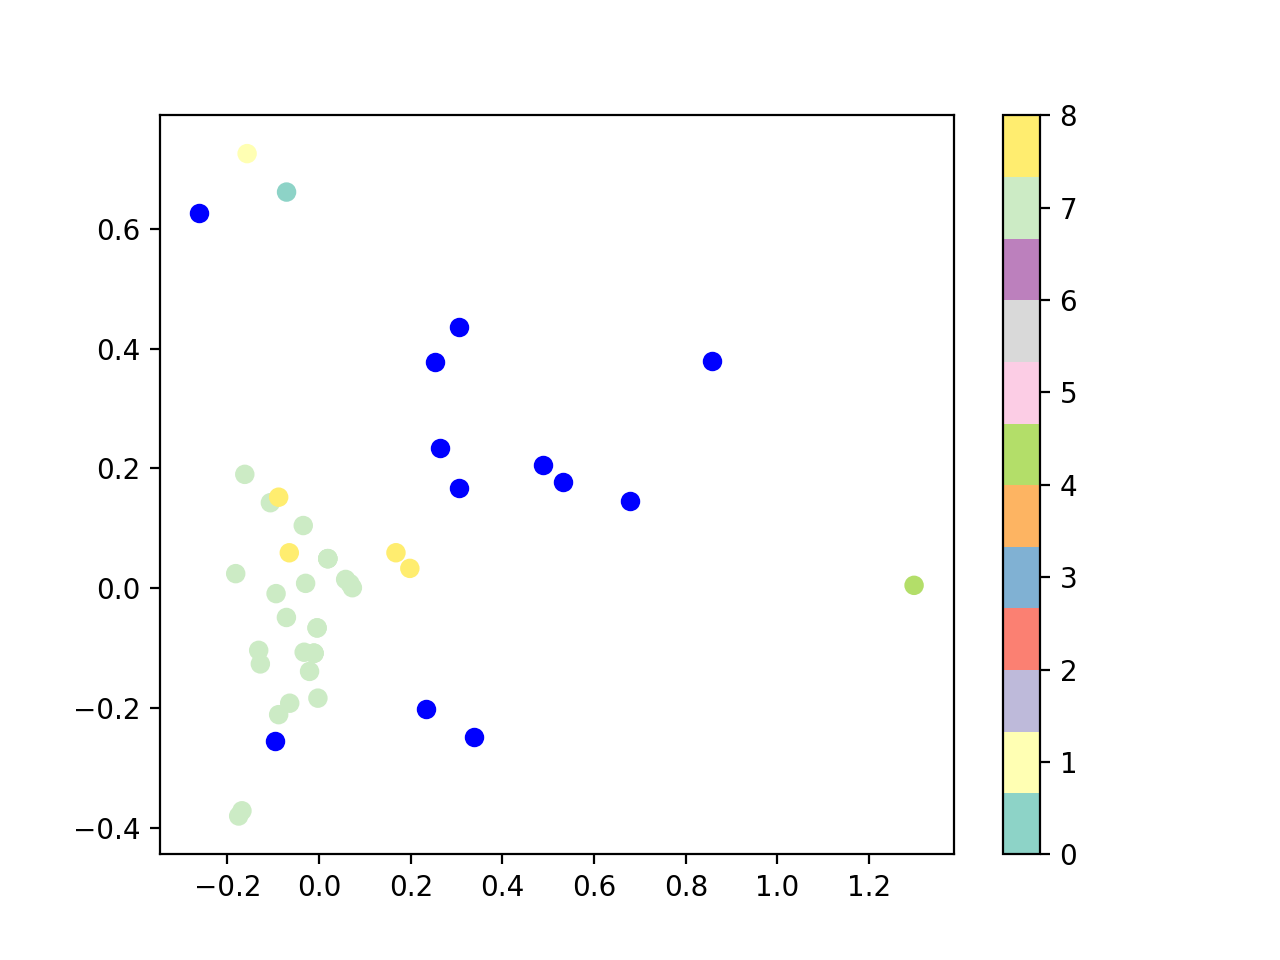

In [448]:
def display_music(clusters, time_divs, note_func):
#     chunks=[]
#     for div in [*time_divs,END]:
#         chunks.append(note_func(div,0,END))
    chunks_arr = np.array(chunks)
    labels = np.zeros(chunks_arr.shape[0])

    chunks_arr_angle = chunks_arr/np.linalg.norm(chunks_arr,axis=0)
    
    for i,ch in enumerate(chunks_arr_angle):
        min_dist = 1000000.
        for j,cl in enumerate(clusters):
            if np.linalg.norm(cl-ch)<min_dist:
                min_dist = np.linalg.norm(cl-ch)
                labels[i]=j
    
    pca = PCA(10)
    emb = pca.fit_transform(chunks_arr_angle)
    clust_emb = np.dot(clusters,pca.components_.T)
    a,b=0,1
    plt.scatter(clust_emb[:,a],clust_emb[:,b],c='b')
    plt.scatter(emb[:,a],emb[:,b],c=labels,cmap='Set3')
    plt.colorbar()
    plt.show()

%matplotlib notebook
display_music(opt_clust[1],opt_clust[0],integral_music_func)

In [1]:
%matplotlib notebook
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.plot(opt_clust[1][i])
    plt.xticks(range(12),['C ','C#','D ','D#','E ','F ','F#','G ','G#','A ','A#','B '],rotation=90)
plt.show()

ModuleNotFoundError: No module named 'distutils'

In [447]:
chunks=[]
divs = [*opt_clust[0],END]
for i,div in enumerate(divs):
    if i == 0:
        continue
    chunks.append(integral_music_func(div,0,END)-integral_music_func(divs[i-1],0,END))
chunks_arr = np.array(chunks)
labels = np.zeros(chunks_arr.shape[0])
for i,ch in enumerate(chunks_arr):
    min_dist = 1000000.
    for j,cl in enumerate(opt_clust[1]):
        if j==5 or j==2 or j==11 or j==10 or j==9:
            continue
        if np.linalg.norm(cl-ch)<min_dist:
            min_dist = np.linalg.norm(cl-ch)
            labels[i]=j
print(np.array(list(zip(np.array(range(len(labels)))+1.,labels))))
#print(chunks)

[[  1.   1.]
 [  2.   7.]
 [  3.   7.]
 [  4.   1.]
 [  5.   1.]
 [  6.   7.]
 [  7.   6.]
 [  8.   1.]
 [  9.   1.]
 [ 10.   7.]
 [ 11.   6.]
 [ 12.   6.]
 [ 13.   7.]
 [ 14.   7.]
 [ 15.   6.]
 [ 16.   7.]
 [ 17.   7.]
 [ 18.   6.]
 [ 19.   1.]
 [ 20.   8.]
 [ 21.   7.]
 [ 22.   1.]
 [ 23.   7.]
 [ 24.   6.]
 [ 25.   6.]
 [ 26.   6.]
 [ 27.   6.]
 [ 28.   6.]
 [ 29.   6.]
 [ 30.   6.]
 [ 31.   6.]
 [ 32.   8.]
 [ 33.   8.]
 [ 34.   8.]]


In [406]:
print(opt_clust[0])
print(nar)

[   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.  272.  288.  304.  320.  336.  352.  368.
  384.  400.  416.  432.  448.  464.  480.  496.  512.  528.]
[[ 60   0   8]
 [ 64   1   8]
 [ 67   2   3]
 ..., 
 [ 64 544 556]
 [ 67 544 556]
 [ 72 544 556]]
